## CP-ALS-QR python/C tutorial

Chances are if you are using python, you are familiar with all of the python dependencies, so this should not be an issue for you.
First off, you should be using VSCODE. I cannot stress this enough. You can do your entire project, have access to git as well as PASCAL all in one file.
Lets get you started with downloading some dependencies. If you are using the PASCAL cluster, you can do everything from here.

In [1]:
## Note that CUPY installs numpy automatically

#%%bash
#pip install cupy_cuda12x==13.0.0  Pillow==10.3.0 scipy==1.8.0


Lets go ahead and import all of the utility files. Note that some of them are commented, since functions have similar names across versions


In [2]:
from cp_utils import *
from np_utils import *
from cp_kernels import *
import cupy as cp
import numpy as np

Lets first talk about a serial implementation. My guess is that if you are using python, you would rather avoid C. BUT, know that it will be a challenge to
implement the CUDA functions if you do this. Highly reccomend writing C code. The good news is that you can interface with C fairly easily with these modules. Lets go ahead and compile the c files. They should already be in this directory.

In [3]:
%%bash
gcc -shared -o naive_c.so -fPIC utils.c

In [4]:
#Now we can safely import the Serial module:
import serial_utils as SERIAL

In [5]:
## initialize RANDOM tensors with the given dimensions in range (0,1)

dim1 = 10
dim2 =10
dim3 = 10
rank = 10
A1,A2,A3,X = SERIAL.init_tensor(dim1,dim2,dim2,rank)


All we have to do now is call our serial function! Everything else is taken care of in the backend. If you would like to implement your own C functions,
See the documentation provided. The function below returns the factor matrices for a given tensor.

In [6]:
A1_SERIAL_OUT,A2_SERIAL_OUT,A3_SERIAL_OUT = SERIAL.decompose_QR_SERIAL(X,rank=rank,verbose=True,max_iter=10)

Epoch: 0 MAX Rel Error:  0.15232347
Epoch: 1 MAX Rel Error:  0.09660863
Epoch: 2 MAX Rel Error:  0.083576284
Epoch: 3 MAX Rel Error:  0.07535013
Epoch: 4 MAX Rel Error:  0.06975234
Epoch: 5 MAX Rel Error:  0.06650559
Epoch: 6 MAX Rel Error:  0.06442442
Epoch: 7 MAX Rel Error:  0.06281922
Epoch: 8 MAX Rel Error:  0.061445978
Epoch: 9 MAX Rel Error:  0.060222607


## Numpy/CUPY serial

I also defined a serial version for numpy, which uses heavily optimized blas operations in the backed. Numpy also helps in the case of 
Tensor operations such as getting the different modes of a tensor. For the following code, I have 2 serial implementations, namely, vanilla CPD and the QR one.

In [7]:
A1_NORMAL,A2_NORMAL,A3_NORMAL = decompose_normal_eqns(X,rank = 10,max_iter=100,rel_tol=.0001,verbose=False) # relative tolerance not implemented
A1_QR,A2_QR,A3_QR = decompose_QR(X,rank = rank,max_iter=100,verbose=False)

Now we would like to use the GPU. Note that we can specify which factor matrices we want, so we can compare our results exactly with different methods.
Lets initialize the original factor matrices and move them to the GPU:

In [8]:
## Same as doing a CUDA memcpy
A1 = cp.array(A1,dtype=np.float32)
A2 = cp.array(A2,dtype=np.float32)
A3 = cp.array(A3,dtype=np.float32)

X = cp.array(X,dtype = np.float32)

In [9]:
## NOTE for the QR kernels function, there are 4 outputs, as opposed to the normal 3

In [10]:
A1_CUDA_NAIVE,A2_CUDA_NAIVE,A3_CUDA_NAIVE = decompose_QR_NAIVE(X,rank=rank,verbose=False) # Uses only CUPY functions (cutensor backend)
A1_KERNELS,A2_KERNELS,A3_KERNELS,residual_history = decompose_QR_KERNELS(X,rank=rank,verbose=True,max_iter=5,cutensor_ttm=False) # Uses Cuda Kernels () without ttm optimization

Epoch: 0 Rel Error:  0.1625093
Epoch: 0 | Loss (A): 4.0041466 | Loss (B): 4.0041466 | Loss (C): 4.0041466
Epoch: 1 Rel Error:  0.10118188
Epoch: 1 | Loss (A): 2.49307 | Loss (B): 2.49307 | Loss (C): 2.4930696
Epoch: 2 Rel Error:  0.08986905
Epoch: 2 | Loss (A): 2.2143276 | Loss (B): 2.2143276 | Loss (C): 2.2143276
Epoch: 3 Rel Error:  0.086519726
Epoch: 3 | Loss (A): 2.1318016 | Loss (B): 2.1318016 | Loss (C): 2.1318018
Epoch: 4 Rel Error:  0.08424867
Epoch: 4 | Loss (A): 2.0758443 | Loss (B): 2.0758443 | Loss (C): 2.0758443


If you would like to do a benchmark test, just call nvprof directly on a .py file. You must go into the .py file and change whatever it is 
you need to change.BE CAREFUL, YOU ARE ON A LOGIN NODE AND IT MIGHT CRASH PASCAL. RUN THIS ON A NODE, OR VERIFY TEST IS SMALL

In [11]:
%%bash
nvprof python3 benchmark.py

INITIALIZING BENCMARK
RANDOM DIMENSIONS


==1744139== NVPROF is profiling process 1744139, command: python3 benchmark.py
==1744139== Warning: Profiling results might be incorrect with current version of nvcc compiler used to compile cuda app. Compile with nvcc compiler 9.0 or later version to get correct profiling results. Ignore this warning if code is already compiled with the recommended nvcc version 


TEST NUMBER:  0
Rank:  286
Dim1:  277
Dim2:  249
Dim3:  252
Cuda Time:  0.4820685386657715
Cutensor Time:  0.3879084587097168


==1744139== Profiling application: python3 benchmark.py
==1744139== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   19.76%  256.19ms       286  895.77us  892.68us  898.79us  cupy_add__float64_float32_float64
                   18.73%  242.83ms         2  121.41ms  121.26ms  121.56ms  ttm_3
                   15.54%  201.46ms       584  344.97us  5.0240us  684.73us  cupy_multiply__float32_float32_float32
                   10.46%  135.67ms         2  67.833ms  66.797ms  68.868ms  ttm_2
                    8.04%  104.29ms        42  2.4832ms  2.3766ms  2.5542ms  void geqr2_alg2_domino_merge<float, float, int=9, bool=0>(int, int, float*, long, float*, float*, float*, float*, int*, int*, int*, int*, int*, int*, int*, int*, int*, int*)
                    7.97%  103.35ms        66  1.5659ms  3.9680us  8.6243ms  cupy_copy__float32_float32
                    3.72%  48.294ms         2  24.147ms  24.141ms  24.153ms  ttm_1
 

## Now lets have some fun!

### We will now ALS on Image data

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

In [13]:
## Convert image data to a tensor
MONA_LISA_original = Image.open('ImageFiles/1024px-Mona_Lisa.jpg')
CLOUDS = Image.open('ImageFiles/1024px-Clouds_over_the_Atlantic_Ocean.jpg')
MONA_LISA = cp.asarray(MONA_LISA_original,dtype=cp.float32)
CLOUDS = cp.array(CLOUDS,dtype=cp.float32)
print("Tensor shape:",MONA_LISA.shape)

Tensor shape: (1549, 1024, 3)


#### Below is the original image so that we can compare

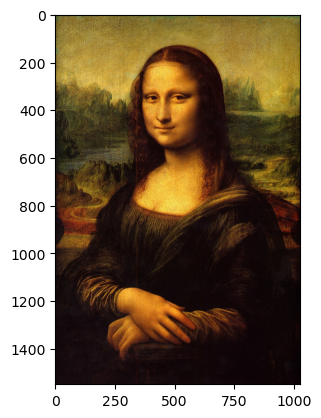

In [14]:
plt.imshow(MONA_LISA.get().astype(np.int32))

In [15]:
## Apply the decomposition as before. Keep verbose on for this one...

A1_ML,A2_ML,A3_ML,residual_history = decompose_QR_KERNELS(MONA_LISA,rank=50,max_iter=20,verbose=True)

Epoch: 0 Rel Error:  0.2501853
Epoch: 0 | Loss (A): 41477.02 | Loss (B): 41477.016 | Loss (C): 41477.02
Epoch: 1 Rel Error:  0.18829094
Epoch: 1 | Loss (A): 31215.85 | Loss (B): 31215.85 | Loss (C): 31215.852
Epoch: 2 Rel Error:  0.18252297
Epoch: 2 | Loss (A): 30259.604 | Loss (B): 30259.604 | Loss (C): 30259.604
Epoch: 3 Rel Error:  0.18050279
Epoch: 3 | Loss (A): 29924.688 | Loss (B): 29924.686 | Loss (C): 29924.688
Epoch: 4 Rel Error:  0.17941657
Epoch: 4 | Loss (A): 29744.61 | Loss (B): 29744.607 | Loss (C): 29744.61
Epoch: 5 Rel Error:  0.17871104
Epoch: 5 | Loss (A): 29627.643 | Loss (B): 29627.643 | Loss (C): 29627.643
Epoch: 6 Rel Error:  0.17820208
Epoch: 6 | Loss (A): 29543.264 | Loss (B): 29543.264 | Loss (C): 29543.264
Epoch: 7 Rel Error:  0.17780888
Epoch: 7 | Loss (A): 29478.078 | Loss (B): 29478.078 | Loss (C): 29478.078
Epoch: 8 Rel Error:  0.1774906
Epoch: 8 | Loss (A): 29425.312 | Loss (B): 29425.312 | Loss (C): 29425.312
Epoch: 9 Rel Error:  0.1772248
Epoch: 9 | Los

Now we reconstruct the image using a function provided:

In [16]:
MONA_RECONSTRUCTED = reconstruct_tensor(A1_ML,A2_ML,A3_ML,rank=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


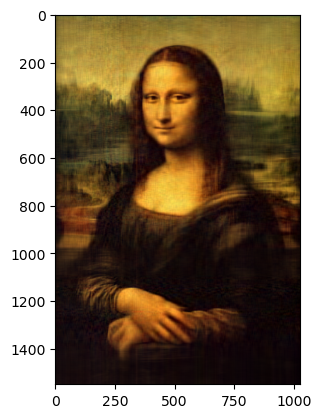

In [17]:
## Now we can plot easily using matplotlib imshow
plt.imshow(MONA_RECONSTRUCTED.get().round().astype(cp.int32)) ## Make sure to move back to the CPU using .get()

##### Lets have a look at the residual history... Make sure verbose is enabled on the decomposition call 

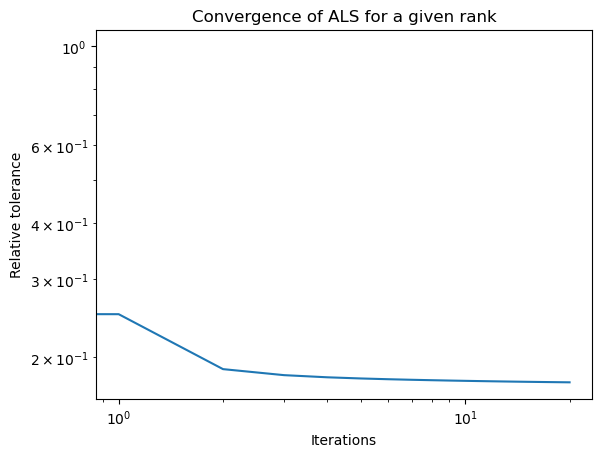

In [18]:
plt.title("Convergence of ALS for a given rank")
plt.ylabel("Relative tolerance")
plt.xlabel("Iterations")
plt.loglog(residual_history)

### Lets look at the pseudo-eigenvalues

In [19]:
## We have to contruct this one manually, by taking the norm of the factor matrices. 
rank = 50
sum = 0
lambdas = []
for i in range(rank):
    sum+= np.einsum('i,j,k->ijk',A1_ML[i,:],A2_ML[i,:],A3_ML[i,:])
    lambdas.append(cp.asnumpy(np.linalg.norm(np.einsum('i,j,k->ijk',A1_ML[i,:],A2_ML[i,:],A3_ML[i,:]).flatten())))
X=sum

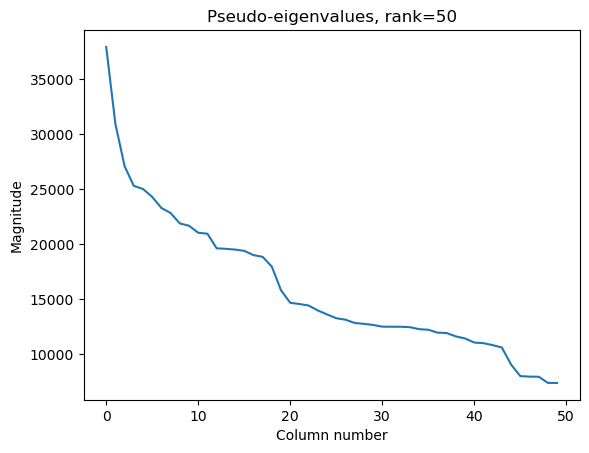

In [20]:
## Plot everything using matplotlib

#Note that I am sorting all the eigenvalues

plt.title("Pseudo-eigenvalues, rank=50")
plt.xlabel("Column number")
plt.ylabel("Magnitude")
plt.plot(sorted(lambdas)[::-1])

Try it for yourself, upload an image and get crackin!